In [1]:
import torch
import sys
from matplotlib import pyplot as plt
plt.rcParams["font.size"] = 24
from einops import rearrange
sys.path.append("../")
from script.datasets.synthetic import MixturedGaussianDataset
from omegaconf import DictConfig
dataset = MixturedGaussianDataset(1000, data_config=DictConfig({"x_dim": 2, "c_dim": 1}))

# Plot data points

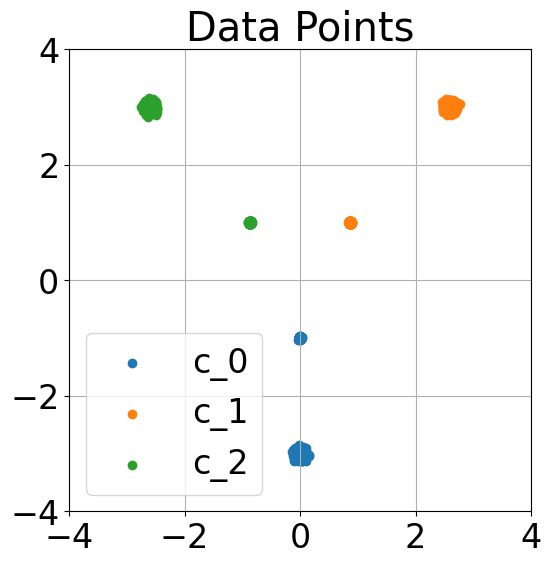

In [2]:
# Split samples by class
samples0 = dataset.xdata[dataset.cdata == 0]
samples1 = dataset.xdata[dataset.cdata == 1]
samples2 = dataset.xdata[dataset.cdata == 2]
samples = dataset.xdata
samples_c = dataset.cdata
plt.figure(figsize=(6,6))
plt.scatter(samples0[:,0], samples0[:,1], label=r"c_0")
plt.scatter(samples1[:,0], samples1[:,1], label=r"c_1")
plt.scatter(samples2[:,0], samples2[:,1], label=r"c_2")
plt.xlim(-4,4)
plt.ylim(-4,4)
plt.xticks([-4,-2,0,2,4])
plt.yticks([-4,-2,0,2,4])
plt.gca().set_aspect("equal")
plt.grid()
plt.title("Data Points")
plt.legend()

# Define Helper Functions

In [3]:
import ot

n_samples = 1000


def otmap(samples):
    barycenter = torch.randn(n_samples, 2) * 0.1
    dist = ot.dist(barycenter, samples)
    a, b = ot.unif(n_samples), ot.unif(n_samples)
    pi = ot.emd(torch.tensor(a), torch.tensor(b), dist)
    otmap = torch.nonzero(pi).squeeze()[:, 1]
    return samples[otmap]
barycenter = torch.randn(n_samples, 2) * 0.1
def otmap_generalized_geodesic(samples0,samples1):
    def ot_(samples):
        n_samples = len(samples)
        dist = ot.dist(barycenter, samples)
        a, b = ot.unif(n_samples), ot.unif(n_samples)
        pi = ot.emd(torch.tensor(a), torch.tensor(b), dist)
        otmap = torch.nonzero(pi).squeeze()[:, 1]
        return otmap
    map0 = ot_(samples0)
    map1 = ot_(samples1)
    maps = [(map1 == i).nonzero().squeeze() for  i in map0]
    return samples1[maps]
def otmap_pairwise(source, target):
    dist = ot.dist(source, target)
    a, b = ot.unif(len(source)), ot.unif(len(target))
    pi = ot.emd(torch.tensor(a), torch.tensor(b), dist)
    otmap = torch.nonzero(pi).squeeze()[:, 1]
    return target[otmap]
beta = 100


def dist(x, y):
    zx, cx = x.split([2, 2], dim=1)
    zy, cy = y.split([2, 2], dim=1)
    return ot.dist(torch.cat([zx, cx * beta], dim=1), torch.cat([zy, cy * beta], dim=1))


def otmap_ours(source, target):
    distance = dist(source, target)
    n_samples = len(source)
    a, b = ot.unif(n_samples), ot.unif(n_samples)
    pi = ot.emd(torch.tensor(a), torch.tensor(b), distance)
    otmap = torch.nonzero(pi).squeeze()[:, 1]
    return target[otmap, :2]
    



# Calculate A2A-FM path

In [4]:
c_0 = dataset.cdata.reshape(-1, 1)
x_0 = dataset.xdata
idx = torch.multinomial(torch.ones(len(c_0)), len(c_0), replacement=False)
x_1 = x_0[idx]
c_1 = c_0[idx]
c_1_hat = c_0[idx]
c_0_hat = dataset.cdata.reshape(-1, 1)
source = torch.cat([x_0, c_0, c_1_hat], dim=-1)
target = torch.cat([x_1, c_0_hat, c_1], dim=-1)
x_1_hat = otmap_ours(source, target)
traj = torch.stack([x_0 * (1 - t) + x_1_hat * t for t in torch.linspace(0, 1, 100)])

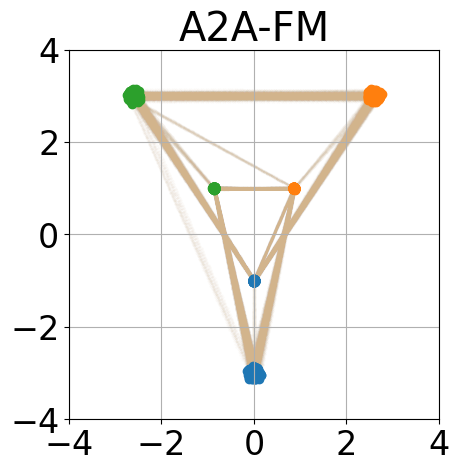

In [5]:
fig, ax = plt.subplots()
ax.scatter(traj[:, :, 0].cpu(), traj[:, :, 1].cpu(), c="tan", alpha=0.1, s=0.1)

ax.scatter(samples0[:,0],samples0[:,1],label=r"c_0")
ax.scatter(samples1[:,0],samples1[:,1],label=r"c_1")
ax.scatter(samples2[:,0],samples2[:,1],label=r"c_2")

ax.set_xlim([-4, 4])
ax.set_ylim([-4, 4])
ax.set_xticks([-4,-2,0,2,4])
ax.set_aspect("equal")
ax.set_title("A2A-FM")
plt.grid()
fig.savefig("ours.png")

# Calculate Ground-truth path (Pairwise OT)

In [ ]:
num_samples = 1000
gt = torch.ones_like(x_1_hat)
pair01 = otmap_pairwise(samples0, samples1)
pair10 = otmap_pairwise(samples1, samples0)
pair00 = otmap_pairwise(samples0, samples0)
pair11 = otmap_pairwise(samples1, samples1)
pair02 = otmap_pairwise(samples0, samples2)
pair20 = otmap_pairwise(samples2, samples0)
pair22 = otmap_pairwise(samples2, samples2)
pair12 = otmap_pairwise(samples1, samples2)
pair21 = otmap_pairwise(samples2, samples1)
gt[torch.bitwise_and(c_0 == 0, c_1 == 1).flatten()] = pair01[torch.bitwise_and(c_0 == 0, c_1 == 1).flatten()[:num_samples]]
gt[torch.bitwise_and(c_0 == 1, c_1 == 0).flatten()] = pair10[torch.bitwise_and(c_0 == 1, c_1 == 0).flatten()[num_samples:2*num_samples]]
gt[torch.bitwise_and(c_0 == 0, c_1 == 0).flatten()] = pair00[torch.bitwise_and(c_0 == 0, c_1 == 0).flatten()[:num_samples]]
gt[torch.bitwise_and(c_0 == 0, c_1 == 2).flatten()] = pair02[torch.bitwise_and(c_0 == 0, c_1 == 2).flatten()[:num_samples]]
gt[torch.bitwise_and(c_0 == 1, c_1 == 1).flatten()] = pair11[torch.bitwise_and(c_0 == 1, c_1 == 1).flatten()[num_samples:2*num_samples]]
gt[torch.bitwise_and(c_0 == 1, c_1 == 2).flatten()] = pair12[torch.bitwise_and(c_0 == 1, c_1 == 2).flatten()[num_samples:2*num_samples]]
gt[torch.bitwise_and(c_0 == 2, c_1 == 1).flatten()] = pair21[torch.bitwise_and(c_0 == 2, c_1 == 1).flatten()[num_samples*2:]]
gt[torch.bitwise_and(c_0 == 2, c_1 == 0).flatten()] = pair20[torch.bitwise_and(c_0 == 2, c_1 == 0).flatten()[num_samples*2:]]
gt[torch.bitwise_and(c_0 == 2, c_1 == 2).flatten()] = pair22[torch.bitwise_and(c_0 == 2, c_1 == 2).flatten()[num_samples*2:]]
trajectory_gt = torch.stack(
    [samples * (1 - t) + gt * t for t in torch.linspace(0, 1, 100)]
)

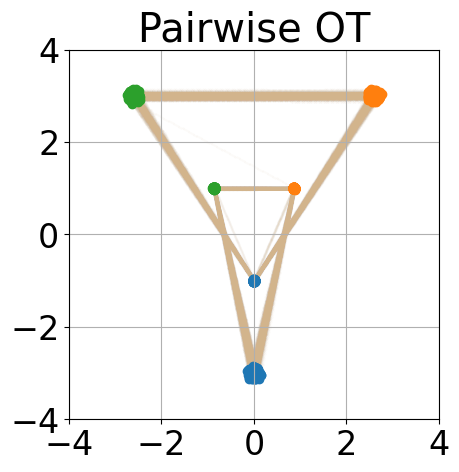

In [8]:
plt.scatter(
    trajectory_gt[:, :, 0].cpu(),
    trajectory_gt[:, :, 1].cpu(),
    c="tan",
    alpha=0.1,
    s=0.1,
)
plt.scatter(samples0[:,0],samples0[:,1],label=r"c_0")
plt.scatter(samples1[:,0],samples1[:,1],label=r"c_1")
plt.scatter(samples2[:,0],samples2[:,1],label=r"c_2")
plt.xlim([-4, 4])
plt.ylim([-4, 4])
plt.xticks([-4,-2,0,2,4])
plt.gca().set_aspect("equal")
plt.grid()
plt.title("Pairwise OT")
plt.savefig("pairwise.png")

# Calculate Generalized Geodesic Path

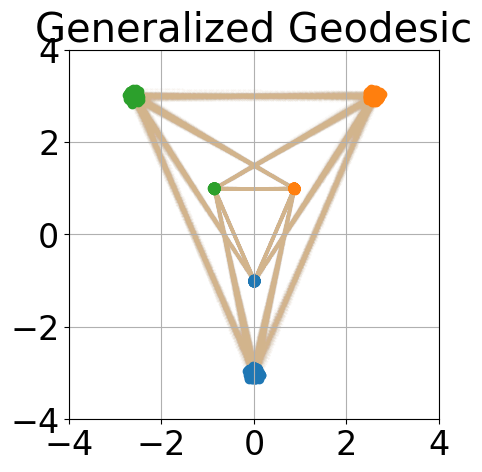

In [9]:
gg = torch.ones_like(x_1_hat)
gengeo01 = otmap_generalized_geodesic(samples0, samples1)
gengeo10 = otmap_generalized_geodesic(samples1, samples0)
gengeo00 = otmap_generalized_geodesic(samples0, samples0)
gengeo11 = otmap_generalized_geodesic(samples1, samples1)
gengeo02 = otmap_generalized_geodesic(samples0, samples2)
gengeo20 = otmap_generalized_geodesic(samples2, samples0)
gengeo22 = otmap_generalized_geodesic(samples2, samples2)
gengeo12 = otmap_generalized_geodesic(samples1, samples2)
gengeo21 = otmap_generalized_geodesic(samples2, samples1)
gg[torch.bitwise_and(c_0 == 0, c_1 == 1).flatten()] = gengeo01[torch.bitwise_and(c_0 == 0, c_1 == 1).flatten()[:num_samples]]
gg[torch.bitwise_and(c_0 == 1, c_1 == 0).flatten()] = gengeo10[torch.bitwise_and(c_0 == 1, c_1 == 0).flatten()[num_samples:2*num_samples]]
gg[torch.bitwise_and(c_0 == 0, c_1 == 0).flatten()] = gengeo00[torch.bitwise_and(c_0 == 0, c_1 == 0).flatten()[:num_samples]]
gg[torch.bitwise_and(c_0 == 0, c_1 == 2).flatten()] = gengeo02[torch.bitwise_and(c_0 == 0, c_1 == 2).flatten()[:num_samples]]
gg[torch.bitwise_and(c_0 == 1, c_1 == 1).flatten()] = gengeo11[torch.bitwise_and(c_0 == 1, c_1 == 1).flatten()[num_samples:2*num_samples]]
gg[torch.bitwise_and(c_0 == 1, c_1 == 2).flatten()] = gengeo12[torch.bitwise_and(c_0 == 1, c_1 == 2).flatten()[num_samples:2*num_samples]]
gg[torch.bitwise_and(c_0 == 2, c_1 == 1).flatten()] = gengeo21[torch.bitwise_and(c_0 == 2, c_1 == 1).flatten()[num_samples*2:]]
gg[torch.bitwise_and(c_0 == 2, c_1 == 0).flatten()] = gengeo20[torch.bitwise_and(c_0 == 2, c_1 == 0).flatten()[num_samples*2:]]
gg[torch.bitwise_and(c_0 == 2, c_1 == 2).flatten()] = gengeo22[torch.bitwise_and(c_0 == 2, c_1 == 2).flatten()[num_samples*2:]]

trajectory_gg = torch.stack(
    [samples * (1 - t) + gg * t for t in torch.linspace(0, 1, 100)]
)
plt.scatter(
    trajectory_gg[:, :, 0].cpu(),
    trajectory_gg[:, :, 1].cpu(),
    c="tan",
    alpha=0.1,
    s=0.1,
)
plt.scatter(samples0[:,0],samples0[:,1],label=r"c_0")
plt.scatter(samples1[:,0],samples1[:,1],label=r"c_1")
plt.scatter(samples2[:,0],samples2[:,1],label=r"c_2")
plt.xlim([-4, 4])
plt.ylim([-4, 4])
plt.grid()
plt.xticks([-4,-2,0,2,4])
plt.gca().set_aspect("equal")
plt.title("Generalized Geodesic")
plt.savefig("gg.png")

In [10]:
print("MSE from Pairwise OT:")
print("Ours", torch.mean((gt - x_1_hat) ** 2))
print("Generalized Geodesic", torch.mean((gt - gg) ** 2))

MSE from Pairwise OT:
Ours tensor(0.0851)
Generalized Geodesic tensor(0.9874)
